# 词汇的星空——词向量（Word Vector）技术

在这节课中，我们学习了如何通过人工神经网络得到单词的向量表达。

首先，我们构建了一个简单的NGram语言模型，根据N个历史词汇预测下一个单词，从而得到每一个单词的向量表示。我们用在集智俱乐部公众号上的一百篇科普文章为例，展示了我们的词向量嵌入效果。

其次，我们学习了如何使用成熟的Google开发的Word2Vec包来进行大规模语料的词向量训练，以及如何加载已经训练好的词向量，从而利用这些词向量来做一些简单的运算和测试。

本文件是集智学园http://campus.swarma.org 出品的“火炬上的深度学习”第VI课的配套源代码

In [19]:
# 加载必要的程序包
# PyTorch的程序包
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 数值运算和绘图的程序包
import numpy as np
import tqdm 
import matplotlib.pyplot as plt
import matplotlib


# 加载机器学习的软件包
from sklearn.decomposition import PCA

#加载Word2Vec的软件包
import gensim as gensim
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from gensim.models.word2vec import LineSentence

#加载‘结巴’中文分词软件包

import jieba

#加载正则表达式处理的包
import re

%matplotlib inline

## 一、NGram 词向量模型

NGram词向量模型的原理是利用一个人工神经网络来根据前N个单词来预测下一个单词，从而得到每个单词的词向量

### 1. 文本预处理

这里我们使用的语料是发表在集智俱乐部公众号上的一百篇科普文章，来展示利用NGram模型训练词向量的方法。集智俱乐部公众号长期关注复杂科学与人工智能研究，追踪学术进展，推介学习资源，科普交叉前沿，ID是：swarma_org，欢迎大家关注。

预处理分为两个步骤：

1、读取文件

2、分词

3、将语料划分为N＋1元组，准备好训练用数据

在这里，我们并没有去除标点符号，一是为了编程简洁，而是考虑到分词会自动将标点符号当作一个单词处理，因此不需要额外考虑。

#### 1). 读入原始文件，筛掉所有标点符号

In [3]:
f = open("swarma_article_small.txt", 'r',encoding='UTF-8')
# 若想加快运行速度，使用下面的语句（选用了三体的其中一章）：
#f = open("3body.txt",'r',encoding='UTF-8') 
text = str(f.read())
f.close()


#### 2)、分词，并去掉标点符号

In [4]:
# 分词
temp = jieba.lcut(text)
words = []
for i in temp:
    #过滤掉所有的标点符号
    i = re.sub("[\s+\.\!\/_,$%^*(+\"\'“”《》?“]+|[+——！，。？、~@#￥%……&*（）：]+", "", i)
    if len(i) > 0:
        words.append(i)

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.002 seconds.
Prefix dict has been built successfully.


#### 3)、构建N+1元组作为训练数据对

In [5]:
# 构建三元组列表.  每一个元素为： ([ i-2位置的词, i-1位置的词 ], 下一个词)
# 我们选择的Ngram中的N，即窗口大小为2
trigrams = [([words[i], words[i + 1]], words[i + 2]) for i in range(len(words) - 2)]
# 打印出前三个元素看看
print(trigrams[:3])

[(['导语', '科学家'], '什么'), (['科学家', '什么'], '时候'), (['什么', '时候'], '能够')]


#### 4). 将每个单词进行编码，构造词典

In [6]:
# 得到词汇表
vocab = set(words)
print(len(vocab))
# 两个字典，一个根据单词索引其编号，一个根据编号索引单词
#word_to_idx中的值包含两部分，一部分为id，另一部分为单词出现的次数
#word_to_idx中的每一个元素形如：{w:[id, count]}，其中w为一个词，id为该词的编号，count为该单词在words全文中出现的次数
word_to_idx = {} 
idx_to_word = {}
ids = 0

#对全文循环，构建这两个字典
for w in words:
    cnt = word_to_idx.get(w, [ids, 0])
    if cnt[1] == 0:
        ids += 1
    cnt[1] += 1
    word_to_idx[w] = cnt
    idx_to_word[ids] = w

7395


In [7]:
word_to_idx

{'导语': [0, 23],
 '科学家': [1, 45],
 '什么': [2, 17],
 '时候': [3, 5],
 '能够': [4, 52],
 '迎来': [5, 3],
 '事业': [6, 4],
 '巅峰': [7, 2],
 '科学': [8, 196],
 '创新': [9, 39],
 '的': [10, 3250],
 '生命周期': [11, 6],
 '是': [12, 375],
 '多久': [13, 4],
 '职业生涯': [14, 7],
 '中': [15, 380],
 '出现': [16, 47],
 '突破性': [17, 4],
 '进展': [18, 15],
 '迹象': [19, 2],
 '是否': [20, 15],
 '存在': [21, 49],
 '什么样': [22, 5],
 '合作': [23, 15],
 '会': [24, 112],
 '带来': [25, 21],
 '成功': [26, 16],
 '年轻': [27, 8],
 '科研人员': [28, 8],
 '如何': [29, 58],
 '将': [30, 120],
 '概率': [31, 9],
 '最大化': [32, 6],
 '这些': [33, 98],
 '都': [34, 82],
 '科学学': [35, 15],
 'the': [36, 45],
 'science': [37, 8],
 'of': [38, 85],
 '正在': [39, 16],
 '探索': [40, 42],
 '问题': [41, 99],
 '当': [42, 32],
 '我们': [43, 180],
 '把': [44, 10],
 '视为': [45, 8],
 '一个': [46, 162],
 '复杂': [47, 284],
 '系统': [48, 361],
 '来': [49, 66],
 '研究': [50, 300],
 '有': [51, 108],
 '令人兴奋': [52, 3],
 '洞察': [53, 2],
 '由': [54, 59],
 '王大顺': [55, 4],
 '美国西北大学': [56, 2],
 '凯洛': [57, 2],
 '格': [58, 3],
 '商学

### 2、构造模型并训练

#### 1). 构造NGram神经网络模型

我们构造了一个三层的网络：

1、输入层：embedding层，这一层的作用是：先将输入单词的编号映射为一个one hot编码的向量，形如：001000，维度为单词表大小。
然后，embedding会通过一个线性的神经网络层映射到这个词的向量表示，输出为embedding_dim

2、线性层，从embedding_dim维度到128维度，然后经过非线性ReLU函数

3、线性层：从128维度到单词表大小维度，然后log softmax函数，给出预测每个单词的概率

In [8]:
class NGram(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGram, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)  #嵌入层
        self.linear1 = nn.Linear(context_size * embedding_dim, 128) #线性层
        self.linear2 = nn.Linear(128, vocab_size) #线性层

    def forward(self, inputs):
        #嵌入运算，嵌入运算在内部分为两步：将输入的单词编码映射为one hot向量表示，然后经过一个线性层得到单词的词向量
        #inputs的尺寸为：1*context_size
        embeds = self.embeddings(inputs)
        #embeds的尺寸为: context_size*embedding_dim
        embeds = embeds.view(1, -1)
        #此时embeds的尺寸为：1*embedding_dim
        # 线性层加ReLU
        out = self.linear1(embeds)
        out = F.relu(out)
        #此时out的尺寸为1*128
        
        # 线性层加Softmax
        out = self.linear2(out)
        #此时out的尺寸为：1*vocab_size
        log_probs = F.log_softmax(out, dim = 1)
        return log_probs
    def extract(self, inputs):
        embeds = self.embeddings(inputs)
        return embeds

#### 2). 开始训练模型

In [20]:
losses = [] #纪录每一步的损失函数
criterion = nn.NLLLoss() #运用负对数似然函数作为目标函数（常用于多分类问题的目标函数）
model = NGram(len(vocab), 10, 2) #定义NGram模型，向量嵌入维数为10维，N（窗口大小）为2
optimizer = optim.SGD(model.parameters(), lr=0.001) #使用随机梯度下降算法作为优化器

#循环100个周期
for epoch in range(20):
    total_loss = torch.Tensor([0])
    for context, target in tqdm.tqdm(trigrams):
    
        # 准备好输入模型的数据，将词汇映射为编码
        context_idxs = [word_to_idx[w][0] for w in context]
        
        context_var = torch.tensor(context_idxs, dtype = torch.long)

        # 清空梯度：注意PyTorch会在调用backward的时候自动积累梯度信息，故而每隔周期要清空梯度信息一次。
        optimizer.zero_grad()

        # 用神经网络做计算，计算得到输出的每个单词的可能概率对数值
        log_probs = model(context_var)

        loss = criterion(log_probs, torch.tensor([word_to_idx[target][0]], dtype = torch.long))

        # 梯度反传
        loss.backward()
        
        # 对网络进行优化
        optimizer.step()
        
        # 累加损失函数值
        total_loss += loss.data
    losses.append(total_loss)
    print('第{}轮，损失函数为：{:.2f}'.format(epoch, total_loss.numpy()[0]))

100%|██████████| 45319/45319 [16:57<00:00, 44.53it/s]


第0轮，损失函数为：372119.91


100%|██████████| 45319/45319 [28:59<00:00, 26.05it/s] 


第1轮，损失函数为：342716.78


100%|██████████| 45319/45319 [16:03<00:00, 47.05it/s] 


第2轮，损失函数为：330694.34


100%|██████████| 45319/45319 [13:10<00:00, 57.36it/s] 


第3轮，损失函数为：324188.78


100%|██████████| 45319/45319 [13:53<00:00, 54.35it/s] 


第4轮，损失函数为：319574.47


100%|██████████| 45319/45319 [17:05<00:00, 44.18it/s] 


第5轮，损失函数为：315700.34


100%|██████████| 45319/45319 [16:07<00:00, 46.84it/s]


第6轮，损失函数为：312131.59


100%|██████████| 45319/45319 [15:23<00:00, 49.09it/s]


第7轮，损失函数为：308689.50


100%|██████████| 45319/45319 [17:50<00:00, 42.33it/s] 


第9轮，损失函数为：301870.09


100%|██████████| 45319/45319 [16:26<00:00, 45.96it/s]


第10轮，损失函数为：298429.22


100%|██████████| 45319/45319 [18:18<00:00, 41.25it/s]


第11轮，损失函数为：294940.81


100%|██████████| 45319/45319 [19:36<00:00, 38.53it/s]


第12轮，损失函数为：291397.78


100%|██████████| 45319/45319 [19:56<00:00, 37.87it/s]


第13轮，损失函数为：287801.47


100%|██████████| 45319/45319 [18:33<00:00, 40.69it/s]


第14轮，损失函数为：284145.50


100%|██████████| 45319/45319 [19:56<00:00, 37.89it/s]


第15轮，损失函数为：280435.44


100%|██████████| 45319/45319 [21:02<00:00, 35.91it/s]


第16轮，损失函数为：276676.59


100%|██████████| 45319/45319 [25:39<00:00, 29.43it/s]


第17轮，损失函数为：272868.53


100%|██████████| 45319/45319 [18:37<00:00, 40.54it/s] 


第18轮，损失函数为：269019.91


100%|██████████| 45319/45319 [14:12<00:00, 53.15it/s] 

第19轮，损失函数为：265134.78


### 3. 结果展示
#### 1). 将向量投影到二维平面进行可视化

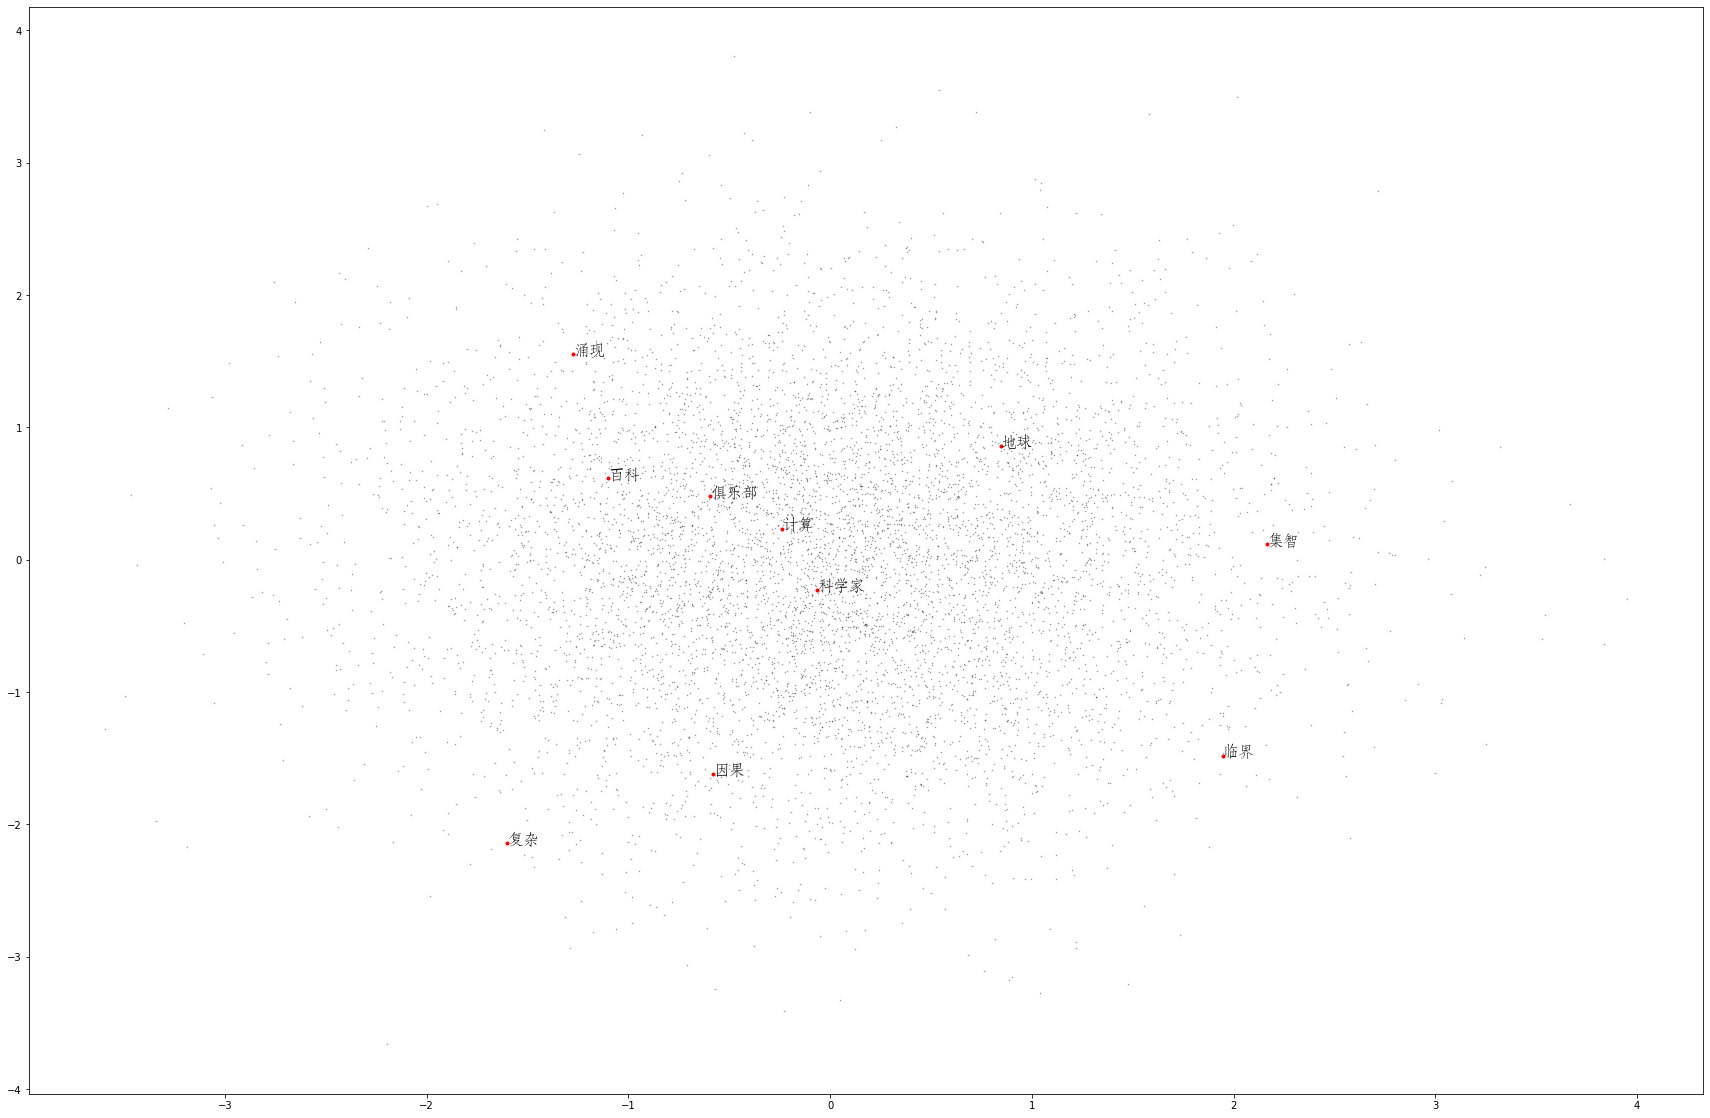

In [24]:
# 从训练好的模型中提取每个单词的向量
vec = model.extract(torch.tensor([v[0] for v in word_to_idx.values()], dtype = torch.long))
vec = vec.data.numpy()

# 利用PCA算法进行降维
X_reduced = PCA(n_components=2).fit_transform(vec)


# 绘制所有单词向量的二维空间投影
fig = plt.figure(figsize = (30, 20))
ax = fig.gca()
ax.set_facecolor('white')
ax.plot(X_reduced[:, 0], X_reduced[:, 1], '.', markersize = 1, alpha = 0.4, color = 'black')


# 绘制几个特殊单词的向量
words = ['科学家','计算','因果','地球','复杂','临界','集智','百科','俱乐部','涌现']
# 设置中文字体，否则无法在图形上显示中文
zhfont1 = matplotlib.font_manager.FontProperties(fname='HuaWenFangSong-1.ttf', size=16)
for w in words:
    if w in word_to_idx:
        ind = word_to_idx[w][0]
        xy = X_reduced[ind]
        plt.plot(xy[0], xy[1], '.', alpha =1, color = 'red')
        plt.text(xy[0], xy[1], w, fontproperties = zhfont1, alpha = 1, color = 'black')
        
plt.savefig('cloud.png')

#### 2). 临近词向量

In [25]:
# 定义计算cosine相似度的函数
def cos_similarity(vec1, vec2):
    
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    norm = norm1 * norm2
    dot = np.dot(vec1, vec2)
    result = dot / norm if norm > 0 else 0
    return result
    
# 在所有的词向量中寻找到与目标词（word）相近的向量，并按相似度进行排列
def find_most_similar(word, vectors, word_idx):
    vector = vectors[word_to_idx[word][0]]
    simi = [[cos_similarity(vector, vectors[num]), key] for num, key in enumerate(word_idx.keys())]
    sort = sorted(simi)[::-1]
    words = [i[1] for i in sort]
    return words

# 与物理靠近的词汇
find_most_similar('物理', vec, word_to_idx)

['物理',
 '内存',
 '快速反应',
 '加',
 '效应',
 '体量',
 '生存',
 '以供',
 '癌性',
 '宏观',
 '信息论',
 '直流',
 '量',
 '以高',
 '万物',
 'Codes',
 '仍',
 '适合',
 '而言',
 '结构特征',
 'matrix',
 '业界',
 '见下文',
 '决策',
 '好地解决',
 'self',
 'rainfall',
 'reversal',
 '重建',
 '微小',
 '轻松',
 'amp',
 '递增',
 '不可',
 '共生生物',
 '论坛',
 '非常低',
 '性别',
 '精确',
 '2011',
 '公共安全',
 '面对',
 '63',
 'de',
 '角速度',
 '越大',
 '戈尔德',
 '处',
 'Markets',
 '健康',
 '防疫',
 '图形',
 '中位数',
 '谁',
 '基础理论',
 '可选',
 '自白',
 '本章',
 '单个',
 '单位',
 '还是',
 '张江',
 '控制系统',
 '能见度',
 '消退',
 '科研人员',
 'Griffith',
 'Gold',
 '用来',
 '立项',
 '蛋白质',
 '分离',
 '1978',
 '胡',
 '端',
 '重叠',
 '变性',
 '代用',
 '得出',
 '流行',
 '界面',
 '新加坡',
 'IM',
 '倒放',
 '入库',
 '世纪末',
 '测量方法',
 '还',
 '细菌',
 '董达',
 '基础',
 'localized',
 '旋涡',
 '不利',
 '碎片',
 '大小不一',
 '③',
 'International',
 '扫描仪',
 '笛卡尔',
 '小到',
 'Biol',
 'Geometric',
 '4A',
 '非洲',
 '亦庄',
 '自由',
 '他花',
 '通过',
 '242John',
 '说明',
 '难以获得',
 '催化剂',
 '型',
 '本科生',
 '花椰菜',
 '新英格兰',
 '热',
 '仅能',
 '个人主义',
 '系统性',
 '高达',
 '疾病诊断',
 '类中',
 '船只',
 '态势',
 'k',
 '研究院',


## 二、Word2Vec

Word2Vec是Google推出的一个开源的词向量计算工具，它被内嵌到了gensim软件包里。
在本课程中，我们主要展示了自己调用Word2Vec训练词向量和读取已经训练好的词向量两种方法，并展示了如何利用词向量来进行一些简单的推理

### 1. 自己训练一个小语料

In [27]:
# 读入文件、分词，形成一句一句的语料
# 注意跟前面处理不一样的地方在于，我们一行一行地读入文件，从而自然利用行将文章分开成“句子”

f = open("swarma_article_small.txt", 'r', encoding='utf-8')

lines = []
all_words = []
for line in f:
    temp = jieba.lcut(line)
    words = []
    for i in temp:
        # 过滤掉所有的标点符号
        i = re.sub("[\s+\.\!\/_,$%^*(+\"\'“”《%》]+|[+——！，。？、~@#￥%……&*（）：；‘]+", "", i)
        if len(i) > 0:
            words.append(i)
    if len(words)> 0:
        lines.append(words)
        for w in words:
            all_words.append(w)

In [28]:
# 得到词汇表
vocab = set(all_words)
print(len(vocab))
# 两个字典，一个根据单词索引其编号，一个根据编号索引单词
#word_to_idx中的值包含两部分，一部分为id，另一部分为单词出现的次数
#word_to_idx中的每一个元素形如：{w:[id, count]}，其中w为一个词，id为该词的编号，count为该单词在words全文中出现的次数
word_to_idx = {} 
idx_to_word = {}
ids = 0

#对全文循环，构建这两个字典
for w in all_words:
    cnt = word_to_idx.get(w, [ids, 0])
    if cnt[1] == 0:
        ids += 1
    cnt[1] += 1
    word_to_idx[w] = cnt
    idx_to_word[ids] = w

model = Word2Vec(lines, vector_size = 20, window = 2, min_count = 0)

7394


In [29]:
model.wv.most_similar('物理', topn = 20)

[(']', 0.7733240127563477),
 ('3141', 0.7032486200332642),
 ('推进', 0.6973986029624939),
 ('纳入', 0.6936282515525818),
 ('encounters', 0.6892205476760864),
 ('值得', 0.6737015247344971),
 ('规范', 0.6487496495246887),
 ('Group', 0.6351106762886047),
 ('环流', 0.6338520050048828),
 ('空气质量', 0.6298693418502808),
 ('弥补', 0.6288836598396301),
 ('兴趣', 0.6250921487808228),
 ('置换', 0.6213077902793884),
 ('负反馈', 0.615544319152832),
 ('亟需', 0.6133674383163452),
 ('扮演着', 0.608871579170227),
 ('临界态', 0.6085649728775024),
 ('限于', 0.6079414486885071),
 ('周晓华', 0.5996989607810974),
 ('除此之外', 0.5926764011383057)]

In [30]:
print(model.wv[all_words[0]])
vec = []
for i,w in enumerate(all_words):
	if i % 1000 == 0:
		print(i,'/',len(all_words))
	vec.append(model.wv[w])
vec = np.array(vec)
# # 从训练好的模型中提取每个单词的向量
# vec = model.extract(torch.tensor([v[0] for v in word_to_idx.values()], dtype = torch.long))
# vec = vec.data.numpy()

# 利用PCA算法进行降维
X_reduced = PCA(n_components=2).fit_transform(vec)

[ 0.03447134  0.00686639 -0.04225481  0.0044881  -0.05040656 -0.01689222
  0.02713538  0.02383876 -0.03434632  0.00850496  0.0325766  -0.03804642
 -0.01231984 -0.01201885 -0.04261053  0.01042     0.03646864  0.00976085
  0.00768552 -0.00863092]
0 / 45246
1000 / 45246
2000 / 45246
3000 / 45246
4000 / 45246
5000 / 45246
6000 / 45246
7000 / 45246
8000 / 45246
9000 / 45246
10000 / 45246
11000 / 45246
12000 / 45246
13000 / 45246
14000 / 45246
15000 / 45246
16000 / 45246
17000 / 45246
18000 / 45246
19000 / 45246
20000 / 45246
21000 / 45246
22000 / 45246
23000 / 45246
24000 / 45246
25000 / 45246
26000 / 45246
27000 / 45246
28000 / 45246
29000 / 45246
30000 / 45246
31000 / 45246
32000 / 45246
33000 / 45246
34000 / 45246
35000 / 45246
36000 / 45246
37000 / 45246
38000 / 45246
39000 / 45246
40000 / 45246
41000 / 45246
42000 / 45246
43000 / 45246
44000 / 45246
45000 / 45246


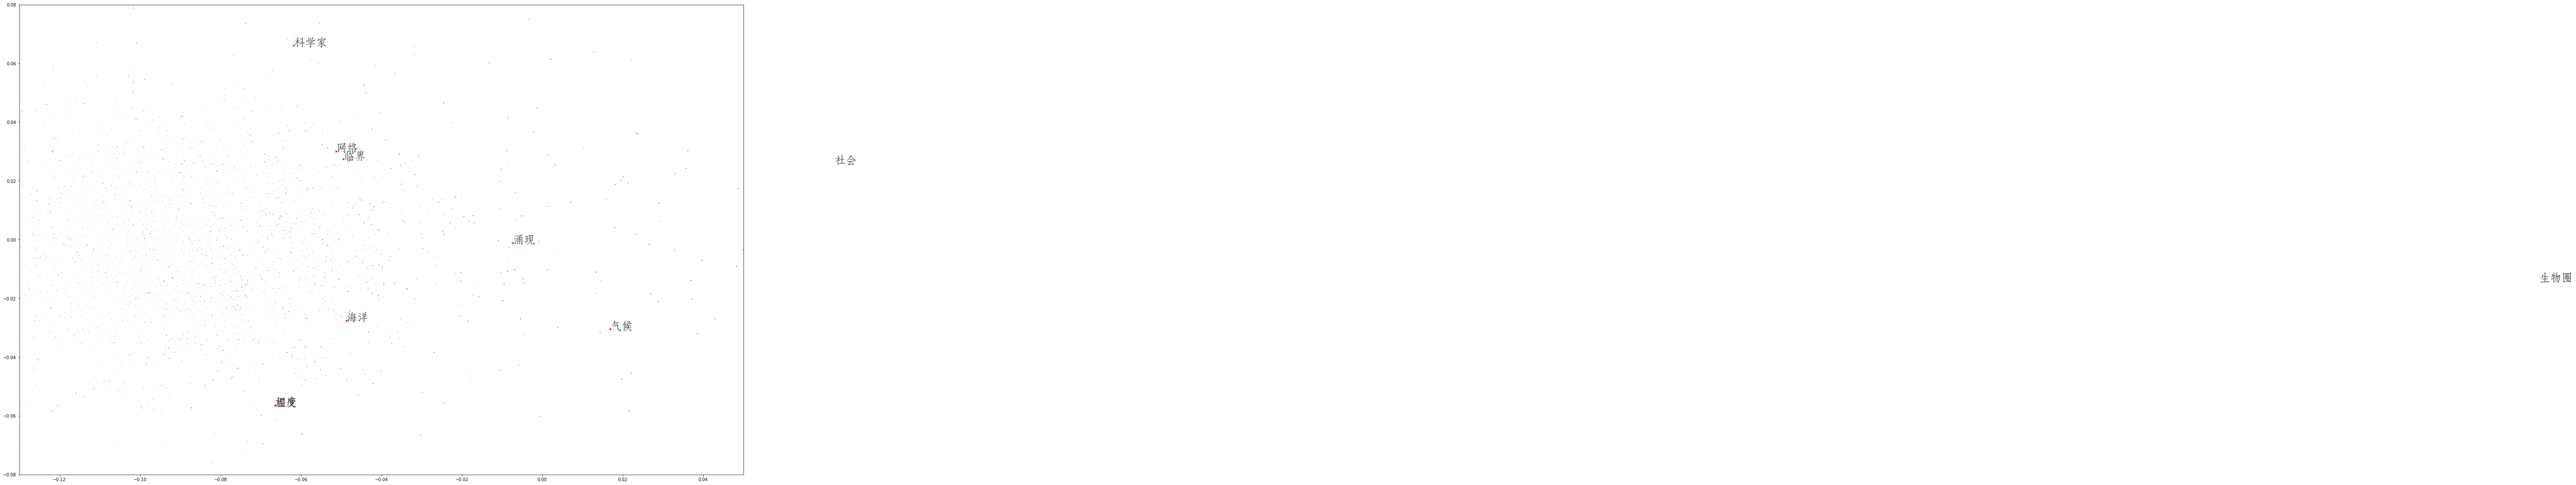

In [31]:
# 绘制所有单词向量的二维空间投影
fig = plt.figure(figsize = (30, 20))
ax = fig.gca()
ax.set_facecolor('white')
ax.plot(X_reduced[:, 0], X_reduced[:, 1], '.', markersize = 1, alpha = 0.1, color = 'gray')


# 绘制几个特殊单词的向量
# words = ['', '', '三体', '质子', '科学', '世界', '文明', '太空', '加速器', '平面', '宇宙', '信息']
words = ['临界','相变','网络','科学家','海洋','气候','温度','湿度','生物圈','社会','涌现']

# 设置中文字体，否则无法在图形上显示中文
zhfont1 = matplotlib.font_manager.FontProperties(fname='.HuaWenFangSong-1.ttf', size=26)
for w in words:
    if w in word_to_idx:
        ind = word_to_idx[w][0]
        xy = X_reduced[ind]
        plt.plot(xy[0], xy[1], '.', alpha =1, color = 'red')
        plt.text(xy[0], xy[1], w, fontproperties = zhfont1, alpha = 1, color = 'black')
plt.xlim(-0.13,0.05)
plt.ylim(-0.08,0.08)
plt.savefig('cloud-1.png')

### 2、调用一个现成的词向量

1). 大规模词向量可视化

该中文词向量库是由尹相志提供，训练语料来源为：微博、人民日报、上海热线、汽车之家等，包含1366130个词向量，
下载地址为：链接：http://pan.baidu.com/s/1gePQAun 密码：kvtg

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第VI课的配套源代码

In [ ]:
# 加载词向量
#需要按照vectors.bin.txt上面写的网盘地址自行下载vectors.bin文件
word_vectors = KeyedVectors.load_word2vec_format('./vectors.bin', binary=True, unicode_errors='ignore')

# len(word_vectors.vocab)

In [44]:
len(word_vectors)

1366130

In [49]:
# PCA降维
rawWordVec = []
word2ind = {}
for i, w in enumerate(word_vectors.key_to_index):
#     print(i)
#     print(w)
#     print(word_vectors[w])
    rawWordVec.append(word_vectors[w])
    word2ind[w] = i
rawWordVec = np.array(rawWordVec)
X_reduced = PCA(n_components=2).fit_transform(rawWordVec)

In [50]:
# 查看相似词
word_vectors.most_similar('物理', topn = 20)

[('化学', 0.7124662399291992),
 ('物理化学', 0.6906830072402954),
 ('物理学', 0.6732755303382874),
 ('力学', 0.6633583903312683),
 ('数学', 0.6431227326393127),
 ('电学', 0.6256975531578064),
 ('原理', 0.6226458549499512),
 ('生物学', 0.6126975417137146),
 ('数学物理', 0.6115936040878296),
 ('电化学', 0.6058179140090942),
 ('非线性', 0.595616340637207),
 ('量子力学', 0.5924553871154785),
 ('热学', 0.5854000449180603),
 ('电磁场', 0.5820313096046448),
 ('物理现象', 0.581839919090271),
 ('凝聚态', 0.5746456384658813),
 ('计算机', 0.5690045356750488),
 ('流体力学', 0.5671141147613525),
 ('化学性', 0.563992440700531),
 ('微积分', 0.5628953576087952)]

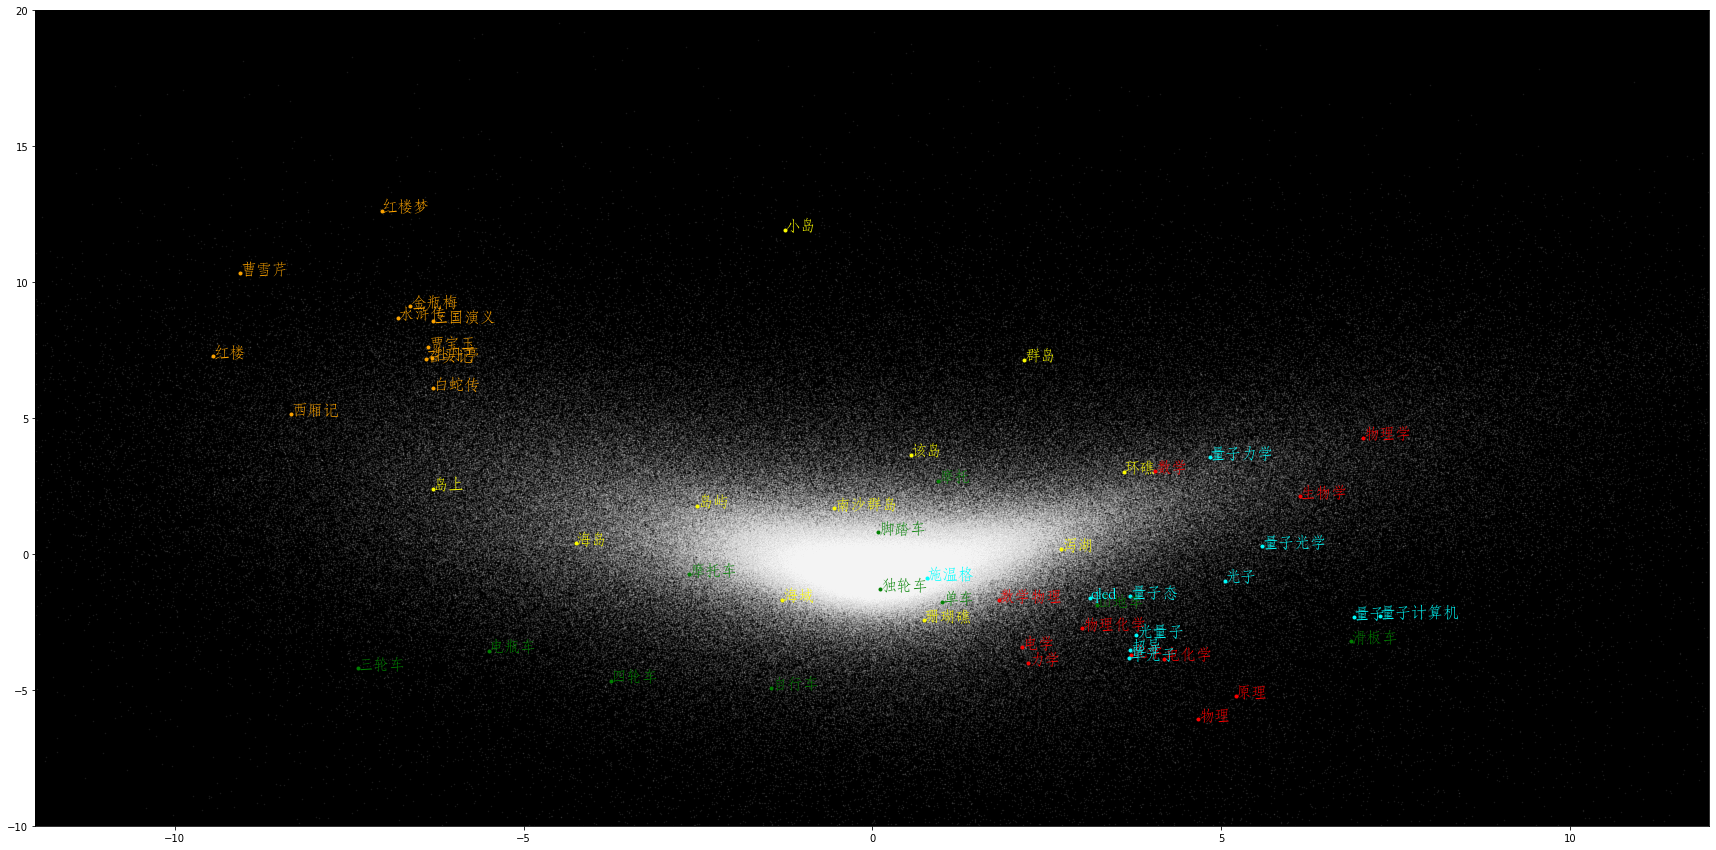

In [52]:
# 绘制星空图
# 绘制所有的词汇
fig = plt.figure(figsize = (30, 15))
ax = fig.gca()
ax.set_facecolor('black')
ax.plot(X_reduced[:, 0], X_reduced[:, 1], '.', markersize = 1, alpha = 0.1, color = 'white')

ax.set_xlim([-12,12])
ax.set_ylim([-10,20])


# 选择几个特殊词汇，不仅画它们的位置，而且把它们的临近词也画出来
words = {'自行车','岛屿','物理','红楼梦','量子'}
all_words = []
for w in words:
    lst = word_vectors.most_similar(w)
    wds = [i[0] for i in lst]
    metrics = [i[1] for i in lst]
    wds = np.append(wds, w)
    all_words.append(wds)


zhfont1 = matplotlib.font_manager.FontProperties(fname='./HuaWenFangSong-1.ttf', size=16)
colors = ['red', 'yellow', 'orange', 'green', 'cyan', 'cyan']
for num, wds in enumerate(all_words):
    for w in wds:
        if w in word2ind:
            ind = word2ind[w]
            xy = X_reduced[ind]
            plt.plot(xy[0], xy[1], '.', alpha =1, color = colors[num])
            plt.text(xy[0], xy[1], w, fontproperties = zhfont1, alpha = 1, color = colors[num])
plt.savefig('88.png',dpi =600)

#### 2). 类比关系实验

In [ ]:
# 女人－男人＝？－国王
words = word_vectors.most_similar(positive=['女人', '国王'], negative=['男人'])
words

In [ ]:
# 北京－中国＝？－俄罗斯
words = word_vectors.most_similar(positive=['北京', '俄罗斯'], negative=['中国'])
words

In [ ]:
# 自然科学－物理学＝？－政治学
words = word_vectors.most_similar(positive=['自然科学', '政治学'], negative=['物理学'])
words

In [ ]:
# 王菲－章子怡＝？－汪峰
words = word_vectors.most_similar(positive=['王菲', '汪峰'], negative=['章子怡'])
words

In [ ]:
# 尽可能多地选出所有的货币
words = word_vectors.most_similar(positive=['美元', '英镑'], topn = 100)
words = word_vectors.most_similar(positive=['美元', '英镑', '日元'], topn = 100)
#words = word_vectors.most_similar(positive=['美元', '英镑', '日元'], negative = ['原油价格', '7800万'], topn = 100)
words

本文件是集智学园http://campus.swarma.org 出品的“火炬上的深度学习”第III课的配套源代码